This notebook demonstrates how the Gliquid code can be used to adjust the prediction of a binary phase diagram with known datapoints taken from measurements.

*WORK IN PROGRESS, WILL BE UPDATED IN NEXT VERSION*

In [1]:
import os
import sys
import plotly.graph_objects as go
import sympy as sp

# Navigate to the folder with gliquid source code
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_root, "src"))

from gliquid_binary import BinaryLiquid, BLPlotter

# Set the environmental variables for cache directory (where data files are stored) and Materials Project API keys.
os.environ["NEW_MP_API_KEY"] = "YOUR_API_KEY_HERE"

c:\Users\willwerj\miniforge3\envs\gliquid-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ce: H_fusion = 6200.0 J/mol, T_fusion = 1071.0 K, T_vaporization = 3633.15 K
Ir: H_fusion = 41120.0 J/mol, T_fusion = 2719.0 K, T_vaporization = 4701.15 K

Reading MPDS json from entry at https://mpds.io/entry/C904533...



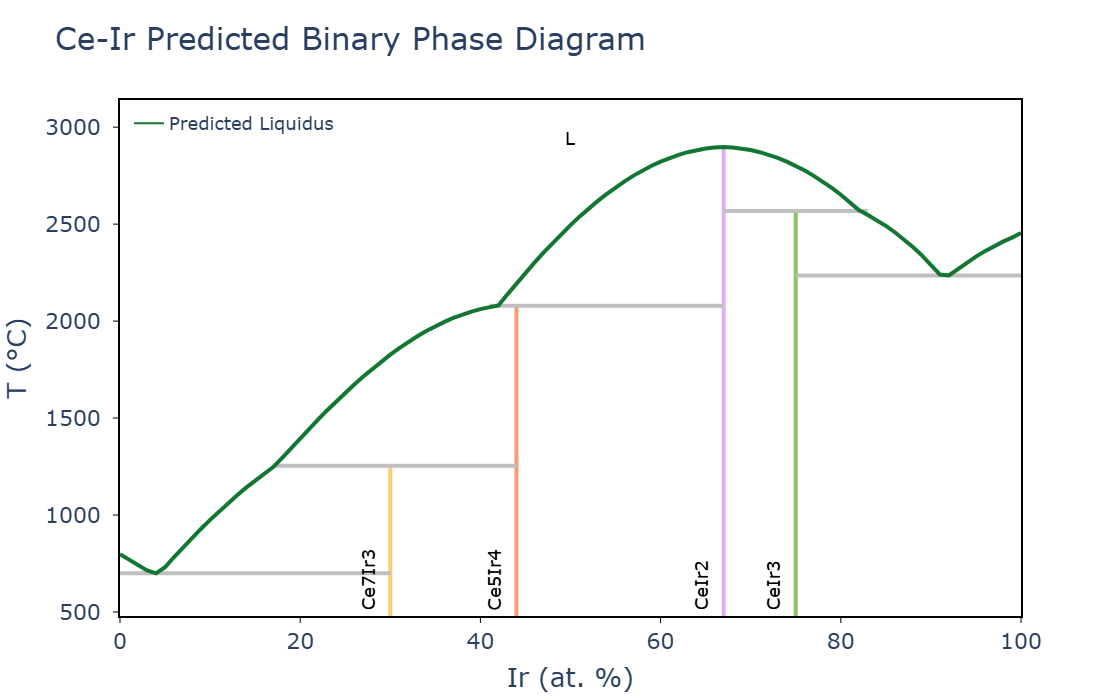

In [2]:
# Instantiate a BinaryLiquid object with a guess for parameter values
parameter_guesses = [-175000, -20, 23000, -12] # [Enthalpy of Mixing, Entropy of Mixing, Enthalpy Skew, Entropy Skew]
ce_ir_system = BinaryLiquid.from_cache('Ce-Ir', params=parameter_guesses)
blp = BLPlotter(ce_ir_system)
blp.show('pred')

In [5]:
def adjust_L0a_from_known_point(bl: BinaryLiquid, known_point: list, tol=10):
    """
    From a known (measured) point, use a bisection algorithm to find the value of L0_a which will generate a liquidus 
    which intersects the known point. 
    """
    # Get present MAE and parameters
    mae, _ = bl.calculate_deviation_metrics()
    print(f"Current complete liquidus MAE: {int(mae)}K")
    print(f"Current parameters: {bl._params}")

    def get_temp_error():
        bl.update_phase_points()
        gen_liq = bl.phases[-1]['points']
        gen_liq_point = min(gen_liq, key=lambda x: abs(x[0] - known_point_k[0]))
        return gen_liq_point[1] - known_point_k[1]

    # Find the temperature error of the generated liquidus to the known point
    known_point_k = [known_point[0], known_point[1] + 273.15] # Assume that known_point is given in Celsius
    temp_error = get_temp_error()
    print(f"The liquidus point generated from current parameter guesses is off by {int(temp_error)} K")

    # Find the values of L0_a that generate a liquidus above and below the known point (at the same composition).
    # Note: this algorithm as-written will only work for L0_a < 0
    ub, lb = None, None
    while not (lb and ub):
        if temp_error > 0:
            ub = bl.get_L0_a()
            bl._params[0] *= 2
        else:
            lb = bl.get_L0_a()
            bl._params[0] /= 2
        temp_error = get_temp_error()

    # Search between the boundary L0_a values to find value that generates a liquidus with temperature error below 'tol'
    # 'tol' is the temperature (Celsius / Kelvin) precision in which the generated liquidus point error must fall below
    while abs(temp_error) > tol:
        mid = 0.5 * (lb + ub)
        bl._params[0] = mid
        temp_error = get_temp_error()
        if temp_error > 0:
            ub = mid
        else:
            lb = mid
                
    mae, _ = bl.calculate_deviation_metrics()
    print(f"Adjusted complete liquidus MAE: {int(mae)}K")
    print(f"Adjusted parameters: {bl._params}")

Current complete liquidus MAE: 567K
Current parameters: [-175000, -20, 23000, -12]
The liquidus point generated from current parameter guesses is off by 221 K
Adjusted complete liquidus MAE: 381K
Adjusted parameters: [-194140.625, -20, 23000, -12]


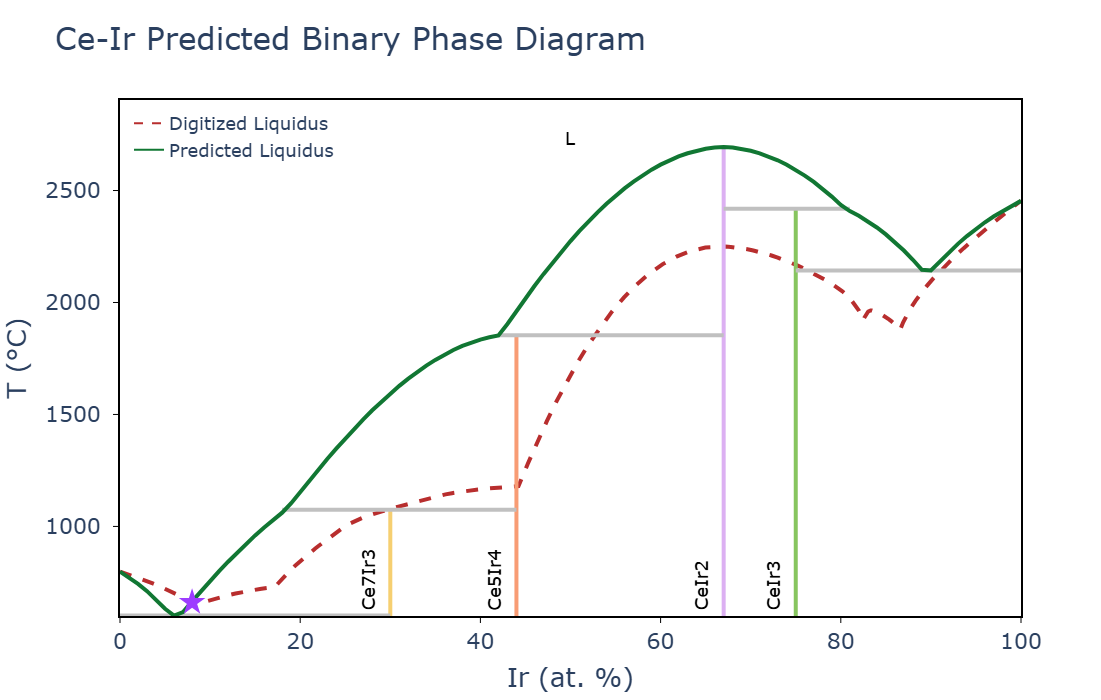

Current complete liquidus MAE: 567K
Current parameters: [-175000, -20, 23000, -12]
The liquidus point generated from current parameter guesses is off by 792 K
Adjusted complete liquidus MAE: 106K
Adjusted parameters: [-240625.0, -20, 23000, -12]


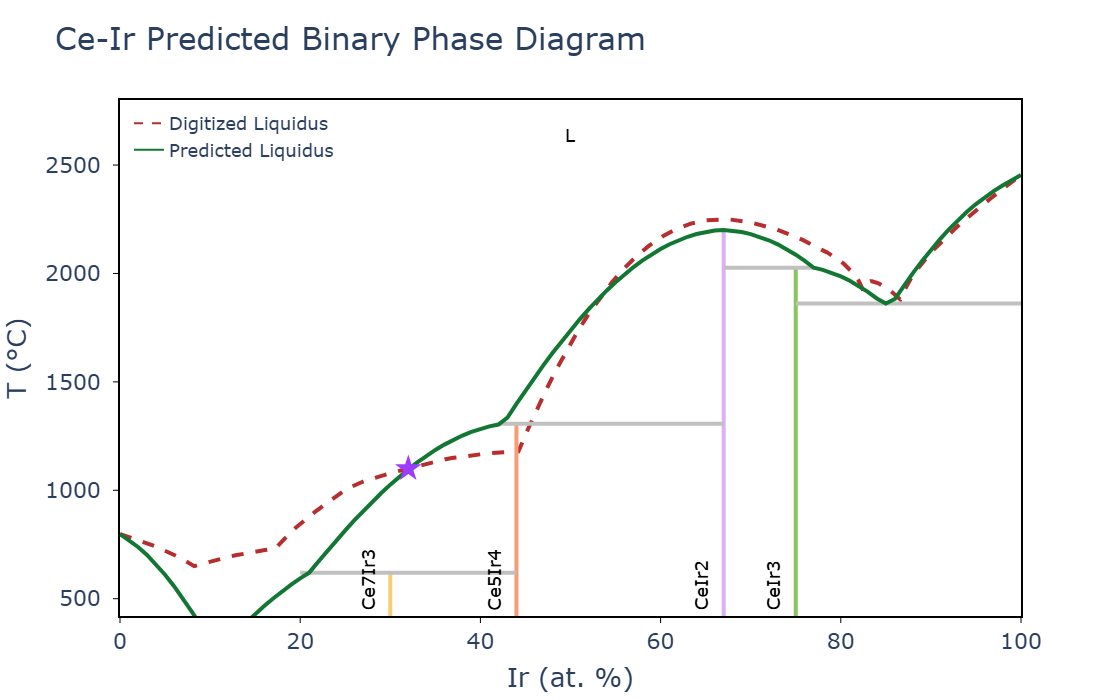

In [6]:
known_points = [[0.08, 661], [0.32, 1100]]

ce_ir_system.update_params(parameter_guesses)
adjust_L0a_from_known_point(ce_ir_system, known_points[0])

fig = blp.get_plot('pred+liq')
fig.add_trace(go.Scatter(
    x=[known_points[0][0]*100], y=[known_points[0][1]],
    mode='markers',
    marker=dict(color='#9D3CFF', size=20, symbol='star'),
    text='known point #1',
    showlegend=False,
))
fig.show()

ce_ir_system.update_params(parameter_guesses)
adjust_L0a_from_known_point(ce_ir_system, known_points[1])

fig = blp.get_plot('pred+liq')
fig.add_trace(go.Scatter(
    x=[known_points[1][0]*100], y=[known_points[1][1]],
    mode='markers',
    marker=dict(color='#9D3CFF', size=20, symbol='star'),
    text='known point #2',
    showlegend=False
))
fig.show()

In [7]:
def adjust_liquidus_from_known_points(bl: BinaryLiquid, known_points: list):
    # Get present MAE and parameters
    original_liq = [p for p in bl.digitized_liq]
    mae, _ = bl.calculate_deviation_metrics()
    print(f"Current complete liquidus MAE: {int(mae)}K")
    print(f"Current parameters: {bl._params}")

    bl.digitized_liq = [[p[0], p[1] + 273.15] for p in known_points]
    mae, _ = bl.calculate_deviation_metrics()
    print(f"Known points (Kelvin): {bl.digitized_liq}")
    print(f"Liquidus MAE from known points: {int(mae)}K")

    a, c = sp.symbols('a c')
    bl.guess_symbols = (a, c)
    l0_a_itl = bl.get_L0_a()
    l1_a_itl = bl.get_L1_a()

    initial_guesses = [[l0_a_itl * 0.9, l1_a_itl * 0.9],
                       [l0_a_itl * 1.1, l1_a_itl * 0.9],
                       [l0_a_itl * 0.9, l1_a_itl * 1.1]]
    mae, _, _ = bl.nelder_mead(tol=1, initial_guesses=initial_guesses, verbose=False)
    print(f"Liquidus MAE from known points: {int(mae)}K")
    bl.digitized_liq = original_liq
    mae, _ = bl.calculate_deviation_metrics()
    print(f"Adjusted complete liquidus MAE: {int(mae)}K")
    print(f"Adjusted parameters: {bl._params}")

In [8]:
known_points = [[0.08, 661], [0.32, 1100]]

ce_ir_system.update_params(parameter_guesses)
adjust_liquidus_from_known_points(ce_ir_system, known_points)
fig = blp.get_plot('pred+liq')

for i, point in enumerate(known_points):
    fig.add_trace(go.Scatter(
        x=[point[0]*100], y=[point[1]],
        mode='markers',
        marker=dict(color='#9D3CFF', size=20, symbol='star'),
        text=f'known point #{i+1}',
        showlegend=False,
    ))
fig.show()

Current complete liquidus MAE: 567K
Current parameters: [-175000, -20, 23000, -12]
Known points (Kelvin): [[0.08, 934.15], [0.32, 1373.15]]
Liquidus MAE from known points: 505K
--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 32.43948984146118 seconds ---
Mean temperature deviation per point between liquidus curves = 6.737362201842838 

Liquidus MAE from known points: 6K
Adjusted complete liquidus MAE: 215K
Adjusted parameters: [-250768.45220453065, -20, 99848.73328456434, -12]


In [9]:
def adjust_liquidus_from_invariant_point(bl: BinaryLiquid, known_eutectic_point: list):
    # Get present MAE and parameters
    mae, _ = bl.calculate_deviation_metrics()
    print(f"Current complete liquidus MAE: {int(mae)}K")
    print(f"Current parameters: {bl._params}")

    # Find the temperature error of the generated liquidus to the known eutectic point
    known_eutectic_point[1] += 273.15 # Assume that known_point is given in Celsius
    gen_liq = bl.phases[-1]['points']
    gen_liq_point = min(gen_liq, key=lambda x: abs(x[0] - known_eutectic_point[0]))
    temp_error = gen_liq_point[1] - known_eutectic_point[1]
    print(f"The liquidus point generated from current parameter guesses is off by {int(temp_error)} K")

    # Get the DFT phases adjacent to the eutectic point
    lhs_phases = [phase for phase in bl.phases[:-1] if phase['comp'] < known_eutectic_point[0]]
    adj_lhs_phase = min(lhs_phases, key=lambda x: abs(x['comp'] - known_eutectic_point[0]))
    rhs_phases = [phase for phase in bl.phases[:-1] if phase['comp'] > known_eutectic_point[0]]
    adj_rhs_phase = min(rhs_phases, key=lambda x: abs(x['comp'] - known_eutectic_point[0]))
 
    # Set up the symbolic equation and first derivative of the liquid free energy
    xb, t, a, b, c, d = sp.symbols('x t a b c d')
    xa = 1 - xb

    R = 8.314
    Ga = (bl.component_data[bl.components[0]][0] -
            t * bl.component_data[bl.components[0]][0] / bl.component_data[bl.components[0]][1])
    Gb = (bl.component_data[bl.components[1]][0] -
            t * bl.component_data[bl.components[1]][0] / bl.component_data[bl.components[1]][1])
    L0 = a + b * t
    L1 = c + d * t

    G_ideal = R * t * (xa * sp.log(xa) + xb * sp.log(xb))
    G_xs = L0 * (xa * xb) + L1 * (xa * xb * (xa - xb))
    G_liq = Ga * xa + Gb * xb + G_ideal + G_xs
    G_prime = sp.diff(G_liq, xb)

    # Set up the invariant equation: dG/dx @ eutectic point = ΔG/ΔX from phases adjacent to eutectic point
    x1, g1 = adj_lhs_phase['comp'], adj_lhs_phase['energy']
    x2, t2 = known_eutectic_point[0], known_eutectic_point[1]
    x3, g3 = adj_rhs_phase['comp'], adj_rhs_phase['energy']
    inv_eqn = sp.Eq(G_prime.subs({xb: x2, t: t2}), (g3 - g1) / (x3 - x1))

    # With one constraint, we can solve for the value of a single parameter with a 'guess' for the other three
    # Here, the 'guessed' parameters are b=L0_b, c=L1_a, d=L1_b. We are solving for the value of a=L0_a
    bl.guess_symbols = (b, c, d)
    bl.constraints = sp.solve([inv_eqn], (a))
    mae = bl.f([bl.get_L0_b(), bl.get_L1_a(), bl.get_L1_b()]) # This will update L0_a and return the liquidus MAE
    print(f"Adjusted complete liquidus MAE: {int(mae)}K")
    print(f"Adjusted parameters: {bl._params}")

In [10]:
ce_ir_system.update_params(parameter_guesses)
adjust_liquidus_from_invariant_point(ce_ir_system, [0.08, 650])

blp = BLPlotter(ce_ir_system)
blp.show('pred+liq')

Current complete liquidus MAE: 567K
Current parameters: [-175000, -20, 23000, -12]
The liquidus point generated from current parameter guesses is off by 232 K
Adjusted complete liquidus MAE: 315K
Adjusted parameters: [-201328.25676837648, -20.0, 23000.0, -12.0]


In [11]:
def adjust_liquidus_from_invariant_point_2_constr(bl: BinaryLiquid, known_eutectic_point: list):
    # Get present MAE and parameters
    mae, _ = bl.calculate_deviation_metrics()
    print(f"Current complete liquidus MAE: {int(mae)}K")
    print(f"Current parameters: {bl._params}")

    # Find the temperature error of the generated liquidus to the known eutectic point
    known_eutectic_point[1] += 273.15 # Assume that known_point is given in Celsius
    gen_liq = bl.phases[-1]['points']
    gen_liq_point = min(gen_liq, key=lambda x: abs(x[0] - known_eutectic_point[0]))
    temp_error = gen_liq_point[1] - known_eutectic_point[1]
    print(f"The liquidus point generated from current parameter guesses is off by {int(temp_error)} K")

    # Get the DFT phases adjacent to the eutectic point
    lhs_phases = [phase for phase in bl.phases[:-1] if phase['comp'] < known_eutectic_point[0]]
    adj_lhs_phase = min(lhs_phases, key=lambda x: abs(x['comp'] - known_eutectic_point[0]))
    rhs_phases = [phase for phase in bl.phases[:-1] if phase['comp'] > known_eutectic_point[0]]
    adj_rhs_phase = min(rhs_phases, key=lambda x: abs(x['comp'] - known_eutectic_point[0]))
 
    # Set up the symbolic equation and first derivative of the liquid free energy
    xb, t, a, b, c, d = sp.symbols('x t a b c d')
    xa = 1 - xb

    R = 8.314
    Ga = (bl.component_data[bl.components[0]][0] -
            t * bl.component_data[bl.components[0]][0] / bl.component_data[bl.components[0]][1])
    Gb = (bl.component_data[bl.components[1]][0] -
            t * bl.component_data[bl.components[1]][0] / bl.component_data[bl.components[1]][1])
    L0 = a + b * t
    L1 = c + d * t

    G_ideal = R * t * (xa * sp.log(xa) + xb * sp.log(xb))
    G_xs = L0 * (xa * xb) + L1 * (xa * xb * (xa - xb))
    G_liq = Ga * xa + Gb * xb + G_ideal + G_xs
    G_prime = sp.diff(G_liq, xb)

    # Set up the invariant equation: dG/dx @ eutectic point = ΔG/ΔX from phases adjacent to eutectic point
    x1, g1 = adj_lhs_phase['comp'], adj_lhs_phase['energy']
    x2, t2 = known_eutectic_point[0], known_eutectic_point[1]
    x3, g3 = adj_rhs_phase['comp'], adj_rhs_phase['energy']
    inv_eqn1 = sp.Eq(G_prime.subs({xb: x2, t: t2}), (g3 - g1) / (x3 - x1))
    inv_eqn2 = sp.Eq(G_liq.subs({xb: x2, t: t2}) + G_prime.subs({xb: x2, t: t2}) * (x1 - x2), g1)

    # With one constraint, we can solve for the value of a single parameter with a 'guess' for the other three
    # Here, the 'guessed' parameters are c=L1_a, d=L1_b. We are solving for the value of a=L0_a and b=L0_b
    bl.guess_symbols = (c, d)
    bl.constraints = sp.solve([inv_eqn1, inv_eqn2], (a, b))
    mae = bl.f([bl.get_L1_a(), bl.get_L1_b()]) # This will update L0_a and L0_b, returning the liquidus MAE
    print(f"Adjusted complete liquidus MAE: {int(mae)}K")
    print(f"Adjusted parameters: {bl._params}")
